### Import dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import lmoments3 as lm3
# import lmoments3.distr
# import lmoments3.stats
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
from cdo import Cdo
cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files1')
# uncomment the below if you want to clean up the temporary directory
cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
from shapely.geometry.polygon import LinearRing

import pyarrow as pa
import pyarrow.parquet as pq

sys.path.append('/home/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

# import my own statistics repository
from mystatsfunctions import LMoments,OLSE

## Matplotlib rcparams setup:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400
matplotlib.rcParams['image.cmap']='cmo.ice'
matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'
matplotlib.rcParams['errorbar.capsize']=5
matplotlib.rcParams['hist.bins']='auto'
plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True):
    if lon:
        ax.set_xticks(np.arange(-20,50,10), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(40,75,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Import data

#### Useful definitions
Defines the PRUDENCE region extents and imports the a land-sea mask.

In [4]:
## define EU domain:
EU_rg = "-27,45,33,73.5"

## define PRUDENCE region extents:
PD_rg = dict(zip(['BI','IP','FR','CE','SC','AL','MD','EE'],['-10,2,50,59','-10,3,36,44','-5,5,44,50','2,16,48,55','5,30,55,70','5,15,44,48','3,25,36,44','16,30,44,55']))
print(PD_rg)

## get land-sea mask & inversion:
lsm = cdo.setctomiss('0',input= '-gtc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')
lsm_inv = cdo.setctomiss('0',input= '-ltc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')

{'BI': '-10,2,50,59', 'IP': '-10,3,36,44', 'FR': '-5,5,44,50', 'CE': '2,16,48,55', 'SC': '5,30,55,70', 'AL': '5,15,44,48', 'MD': '3,25,36,44', 'EE': '16,30,44,55'}


#### Data for panel A:

In [5]:
## Panel a: max temps over 25-27th (E-OBS)

a_maxtempanom = cdo.timmax(input="-ydaysub -sellonlatbox,"+EU_rg+" -seldate,2019-02-25,2019-02-27 ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc -sellonlatbox,"+EU_rg+" -ydaymean -selyear,1981/2010 -selmon,2 -selday,25/27 ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc",returnCdf=True)

In [6]:
## Panel a: Z500 field over 21-27th

a_z500 = cdo.timmean(input="-seldate,2019-02-25,2019-02-27 -sellevel,500 -selname,z ../../ERA5/EU_FEB_19/ERA5_plev_500-850_2019.nc",returnCdf=True)

#### Data for panel B:

In [7]:
## Panel b: tcc over 25-27th

b_tcc = cdo.timmean(input="-seldate,2019-02-25,2019-02-27 -selname,tcc ../../ERA5/EU_FEB_19/ERA5_sfc_2019.nc",returnCdf=True)

In [8]:
## Panel b: mslp anomaly over 21-27th

b_mslpanom = cdo.timmean(input="-ydaysub -seldate,2019-02-25,2019-02-27 -selname,msl ../../ERA5/EU_FEB_19/ERA5_sfc_2019.nc -ydaymean -selyear,1981/2010 -selmon,2 -selday,21/27 -selname,msl ../../ERA5/EU_FEB_19/ERA5_sfc_1981-2018_packed.nc",returnCdf=True)

#### Data for panel C:

In [9]:
## Panel c: E-OBS event rank since 1950

### yearly max in E-OBS (up to 2019-02-24):
eobs_histmax = cdo.sellonlatbox(EU_rg,input='-yearmax -shifttime,+1mo -seldate,1950-01-01,2019-02-24 -selmon,12,1,2 ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc',returnCdf=True)
### maximum during the event
eobs_eventmax = cdo.sellonlatbox(EU_rg,input='-timmax -seldate,2019-02-25,2019-02-27 ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc',returnCdf=True)

c_txrank = 71-np.ma.array(np.ma.argsort(np.ma.argsort(np.ma.concatenate([eobs_histmax['tx'][:],eobs_eventmax['tx'][:]],axis=0),endwith=False,axis=0),endwith=False,axis=0)[-1],mask=eobs_eventmax['tx'][0].mask)

In [10]:
## Panel c: Record breaking stations (HadISD)

### get HadISD

hadisd_meta = pd.read_csv('../../HadOBS/download/hadisd_station_info_v311_202003p.txt',delim_whitespace=True,names = ['id','lat','lon','elev'],index_col=0)
get_other_info = pd.read_csv('../../HadOBS/download/hadisd_station_fullinfo_v311_202001p.txt',header=None)
new_info_df = pd.DataFrame(index=[x.iloc[0].split(' ')[0] for i,x in get_other_info.iterrows()])
new_info_df['start_date'] = [x.iloc[0].split(' ')[-2] for i,x in get_other_info.iterrows()]
new_info_df['end_date'] = [x.iloc[0].split(' ')[-1] for i,x in get_other_info.iterrows()]
hadisd_meta=hadisd_meta.join(new_info_df)
hadisd_winter_max = pd.read_csv('../../HadOBS/EU_dataframes/EU_temperatures_DJFmax.csv',index_col=0,parse_dates=True)
hadisd_winter_max = hadisd_winter_max.loc[:,(hadisd_winter_max.iloc[-3:].isna().sum(axis=0)!=3)&(hadisd_winter_max.notnull().sum()>30)]
hadisd_rank = pd.DataFrame(index=hadisd_winter_max.columns)
hadisd_rank['RANK'] = hadisd_winter_max.rank(method='max',ascending=False).iloc[-3:].min()
hadisd_rank['LAT'] = hadisd_meta.loc[hadisd_rank.index,'lat']
hadisd_rank['LON'] = hadisd_meta.loc[hadisd_rank.index,'lon']
hadisd_rank['PREV_MAX'] = hadisd_winter_max.iloc[:-3].max()
hadisd_rank['PREV_MAX_YEAR'] = hadisd_winter_max.iloc[:-3].idxmax().apply(lambda x: x.year)
hadisd_rank['EVENT_MAX'] = hadisd_winter_max.iloc[-3:].max()
hadisd_rank['EVENT_DATE'] = hadisd_winter_max.iloc[-3:].idxmax()-pd.DateOffset(years=100)

c_records = hadisd_rank.loc[hadisd_rank.RANK==1,['LAT','LON']]

#### Data for panel D:

In [11]:
## Panel d: E-OBS timeseries of yearly maxima

def get_EOBS_RG_meanmax_hist(RG):
    histdata = xr.open_dataset(cdo.yearmax(input='-fldmean -shifttime,+1mo -sellonlatbox,'+PD_rg[RG]+' -selmon,12,1,2 -seldate,1950-01-01,2018-03-01 -selname,tx ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc',options='-b F64')).tx.squeeze().to_pandas()
    histdata.index = [x.year for x in histdata.index]
    histdata.loc['2019'] = cdo.timmax(input='-fldmean -sellonlatbox,'+PD_rg[RG]+' -seldate,2019-02-25,2019-02-27 -selname,tx ../../E-OBS/tx_ensmean_0.1deg_reg_E-OBS.nc',options='-b F64',returnArray='tx').data.flatten()[0]
    return histdata

P1=multiprocessing.Pool(processes=8)
eobs_histseries = P1.map(get_EOBS_RG_meanmax_hist,PD_rg.keys())
P1.close()

In [12]:
## Panel d: compute return period of the 2019 event in the series of DJF maxima

d_histseries = pd.concat(eobs_histseries,axis=1,keys=PD_rg.keys())

## Create the figure

Text(0, 1.16, 'D')

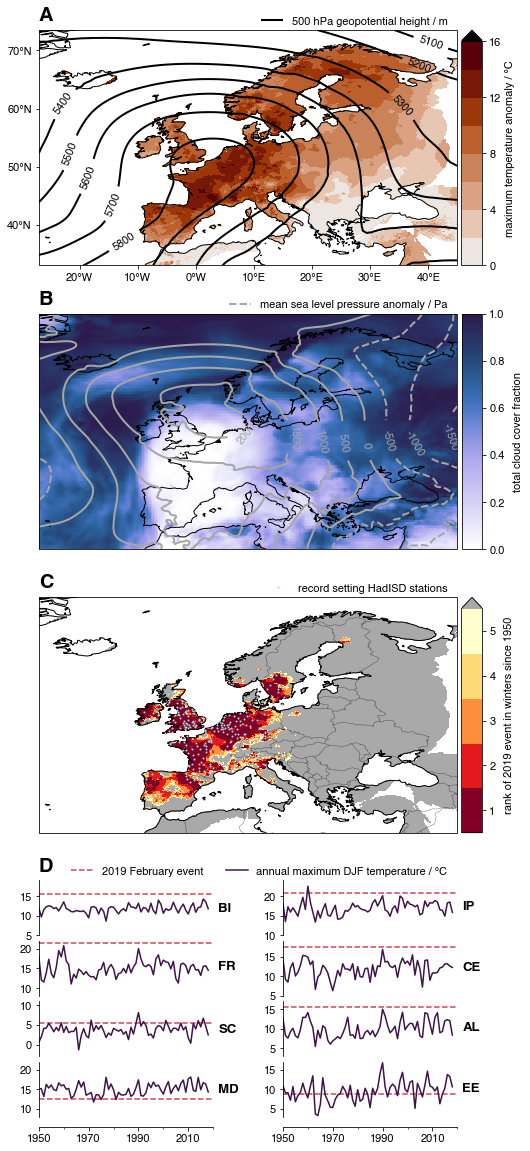

In [13]:
matplotlib.rcParams['font.size']=11

fig = plt.figure(figsize=(7.5,20))
gs = fig.add_gridspec(4,1,wspace=0,hspace=0.2)

# Panel a

ax = [fig.add_subplot(gs[0],projection=crs.PlateCarree())]

## Plot tmax anomaly
nlev = 8
vrange=[0,16]
cmap_base = SCM6.vik(np.linspace(0.5,1,nlev))
# cmap_base[[3,4],-1] = 0
cmap = matplotlib.colors.ListedColormap(cmap_base)
cmap.set_over('k')
norm=matplotlib.colors.Normalize(*vrange)
tmax_field = ax[0].pcolormesh(a_maxtempanom['longitude'][:],a_maxtempanom['latitude'][:],a_maxtempanom['tx'][:].squeeze(),cmap=cmap,norm=norm,rasterized=True)
    
axins = inset_axes(ax[0], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.01, 0.00, 1, 1),bbox_transform=ax[0].transAxes,borderpad=0)
cbar = plt.colorbar(tmax_field,cax=axins,ticks=np.arange(-8,25,4),extend='max')
cbar.set_label('maximum temperature anomaly / \N{DEGREE SIGN}C',labelpad=3)

Z500_contour = ax[0].contour(a_z500['longitude'][:],a_z500['latitude'][:],a_z500['z'][:].squeeze()/9.80665,levels=np.linspace(4700,5800,12),colors='k',linewidths=2)
Z500_contour.collections[0].set_label('500 hPa geopotential height / m')
Z500_labels = ax[0].clabel(Z500_contour,fmt=r'%4d',manual=[[x,-32/17*x+33-320/17] for x in [-12,-16,-18,-20,-26]]+[[40,70],[37.5,65],[35,60]])

add_lat_lon_ticks(ax[0])

# Panel b

ax += [fig.add_subplot(gs[1],projection=crs.PlateCarree())]

## Plot tcc anomaly
nlev = 10
vrange=[0,1]
cmap_base = SCM6.davos.reversed()(np.linspace(0,1,nlev))
# cmap_base[:,-1] = 0.9
cmap = matplotlib.colors.ListedColormap(cmap_base)
norm=matplotlib.colors.Normalize(*vrange)
tcc_field = ax[1].pcolormesh(b_tcc['longitude'][:],b_tcc['latitude'][:],b_tcc['tcc'][:].squeeze(),cmap=SCM6.devon.reversed(),norm=norm,rasterized=True) # cmocean.cm.dense
    
axins = inset_axes(ax[1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.01, 0.00, 1, 1),bbox_transform=ax[1].transAxes,borderpad=0)
cbar = plt.colorbar(tcc_field,cax=axins,ticks=np.linspace(0,1,6))
cbar.set_label(r'total cloud cover fraction',labelpad=8)

## Plot mslp
mslp_contour = ax[1].contour(b_mslpanom['longitude'][:],b_mslpanom['latitude'][:],b_mslpanom['msl'][:].squeeze(),levels=np.linspace(-2000,2000,9),colors='0.65',linewidths=2)
mslp_contour.collections[0].set_label('mean sea level pressure anomaly / Pa')
### compute nice label locations along a straight line:
mslp_labels = ax[1].clabel(mslp_contour,fmt=r'%4d',manual=[[x,51.5] for x in [10,15,23,25,28,32,38,43]])
# [l.set_rotation(0) for l in mslp_labels] # use if you want rotated contour labels

# Panel c

ax += [fig.add_subplot(gs[2],projection=crs.PlateCarree())]
cmap_base = matplotlib.cm.YlOrRd.reversed()(np.linspace(0,1,5))
cmap = matplotlib.colors.ListedColormap(cmap_base)
cmap.set_over('darkgrey')

EOBS_rank = ax[2].pcolormesh(eobs_eventmax['longitude'][:],eobs_eventmax['latitude'][:],c_txrank,cmap=cmap,norm=matplotlib.colors.Normalize(0.5,5.5),rasterized=True)
ax[2].add_feature(cartopy.feature.BORDERS.with_scale('50m'),lw=0.5,alpha=0.5)

hadisd_rank_plot = ax[2].plot(c_records['LON'],c_records['LAT'],'.',c='lightblue',ms=2,label='record setting HadISD stations')

axins = inset_axes(ax[2], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.01, 0.00, 1, 1),bbox_transform=ax[2].transAxes,borderpad=0)
cbar=plt.colorbar(EOBS_rank,cax=axins,extend='max')
cbar.set_label(r'rank of 2019 event in winters since 1950',labelpad=8)

# Panel d

ts_clrs = cmocean.cm.matter.reversed()([0.05,0.5])
gs0 = gs[3].subgridspec(4,2,wspace=0.4,hspace=0.1)
RGs = PD_rg.keys()
ax += [dict(zip(RGs,[fig.add_subplot(gs0[i]) for i in np.arange(8)]))]

ylims = dict(zip(['BI', 'IP', 'FR', 'CE', 'SC', 'AL', 'MD', 'EE'],[(5,19),(10,24),(8,22),(5,19),(-3,11),(3,17),(8,22),(3,17)]))

for RG in RGs:

    ax[-1][RG].plot(d_histseries.loc[list(range(1950,2019)),RG],color=ts_clrs[0])
    ax[-1][RG].axhline(d_histseries.loc['2019',RG],color=ts_clrs[1],zorder=0,ls='--')
    
#     ax[-1][RG].axhline(figureES1_panel6_histseries.loc[range(1981,2010),RG].mean(),color='tab:gray',lw=1,zorder=0)
#     [ax[-1][RG].axhline(figureES1_panel6_histseries.loc[range(1981,2010),RG].mean()+figureES1_panel6_histseries.loc[range(1981,2010),RG].std()*x,color='tab:gray',lw=1,zorder=0,ls=':') for x in [-2,2]]
    
text_align = dict(zip(RGs,['bottom']*6+['top']*2))
for RG in list(RGs):#['BI','IP','SC','AL']:
    [ax[-1][RG].spines[loc].set_visible(False) for loc in ['bottom','right','top']]
    ax[-1][RG].text(2022,d_histseries.loc[range(1981,2011),RG].mean(),RG,fontweight='bold',ha='left',va='center',fontsize='large')
    
[a.spines['bottom'].set_visible(True) for a in list(ax[-1].values())[6:]]
[a.spines['bottom'].set_position(('outward',10)) for a in list(ax[-1].values())[6:]]
[a.patch.set_alpha(0) for a in ax[-1].values()]
[a.set_xticks([]) for a in list(ax[-1].values())[:6]]
[a.set_xticks(np.arange(1950,2031,20)) for a in list(ax[-1].values())[6:]]
[a.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))  for a in list(ax[-1].values())[6:]]
[a.set_xlim(1950,2020) for a in ax[-1].values()]
[ax[-1][RG].set_yticks(np.arange(-5,35,5)) for RG in RGs]
[ax[-1][RG].set_ylim(*ylims[RG]) for RG in RGs]
[a.ticklabel_format(style='plain') for a in list(ax[-1].values())[6:]]

handles0 = [matplotlib.lines.Line2D([0],[0], c=x, ls=['--','-'][i], label=['2019 February event','annual maximum DJF temperature / \N{DEGREE SIGN}C'][i]) for i,x in enumerate(ts_clrs[::-1])]

[a.coastlines('50m') for a in ax[:-1]]
[a.set_xlim(-27,45) for a in ax[:-1]]
[a.set_ylim(33,73.5) for a in ax[:-1]]
[a.text(0,1.04,['A','B','C','D'][i],transform=a.transAxes,fontweight='bold',fontsize=20) for i,a in enumerate(ax[:-1])]
[a.legend(loc='lower right',bbox_to_anchor=(1,0.975),frameon=False,ncol=5) for i,a in enumerate(ax[:-1])]
ax[-1]['IP'].legend(handles=handles0,loc='lower right',bbox_to_anchor=(1,0.9),frameon=False,ncol=5)
ax[-1]['BI'].text(0,1.16,'D',transform=ax[-1]['BI'].transAxes,fontweight='bold',fontsize=20)
# ax[2][0].legend(loc='lower right',bbox_to_anchor=(1,1),frameon=False,ncol=5)

# [fig.savefig('FIGS/Fig1.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
# fig.dpi=300

## Appendix: show bounding boxes of PRUDENCE regions

(33.0, 73.5)

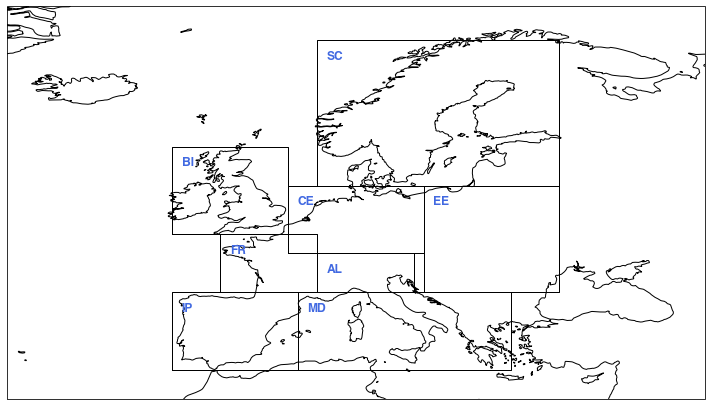

In [14]:
fig,ax = plt.subplots(figsize=(12.5,7.5),subplot_kw=dict(projection=crs.PlateCarree()))

## add regional boundaries to the map:
for RG in PD_rg.keys():
    RG_lons = np.array(PD_rg[RG].split(',')).astype(int)[[0,0,1,1,0]]
    RG_lats = np.array(PD_rg[RG].split(',')).astype(int)[[2,3,3,2,2]]
    ax.plot(RG_lons,RG_lats,'k',transform=crs.PlateCarree(),lw=1)
    ax.text(RG_lons[0]+1,RG_lats[2]-1,RG,color='royalblue',va='top',ha='left',fontweight='bold',fontsize=12)
    
ax.coastlines()
ax.set_xlim(-27,45)
ax.set_ylim(33,73.5)